In [27]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
from ipywidgets import Layout, Button, Box
from nested_dict import nested_dict
import ipywidgets as widgets

import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set_style("whitegrid")

In [28]:
artifacts_dir = "/Users/shubham/sandmark-nightly/parallel/"
pausetimes_dir = "/Users/shubham/sandmark-nightly/pausetimes/parallel"

In [29]:
bench_files = []

artifacts_path = artifacts_dir.split("/parallel/")[0]

for root, dirs, files in os.walk(artifacts_dir):
    for file in files:
        if file.endswith("_1.orunchrt.summary.bench"):
            f = root.split("/parallel/")
            bench_files.append((os.path.join(root, file)))

In [30]:
def files_to_dict(files):
    benches = nested_dict(2, list)
    for x in files:
        l = x.split("/parallel/")[1]
        d = l.split("/")
        host         = d[0]
        timestamp    = d[1]
        commit       = d[2]
        variant      = d[3]
        variant_root = d[3].split('_')[0]
        variant_stem = d[3].split('_')[1]
        value        = variant_root + '+' + commit + '_' + variant_stem
        benches[host][timestamp].append(value)
    benches = dict(benches)
    for i in benches.items():
        benches[i[0]] = dict(sorted(i[1].items(), key=lambda t : t[0], reverse=True))
    return benches

benches = files_to_dict(bench_files)

In [54]:
def f(x): return x

def disp(benches):
    def select_host(host):
        timestampW.options = benches[host]
    
    def select_commit(timestamp):
        variantW.options = timestamp
    
    def do_nothing(variant):
        return None
    
    hostW = widgets.Dropdown(options=benches.keys(), description='Host', value='turing', disabled=False)
    hostS = hostW.value
    hostD = widgets.interactive(select_host, host=hostW)

    timestampW = widgets.Dropdown(options=benches[hostS].keys(), description='Timestamp', disabled=False)
    timestampS = timestampW.value
    timestampD = widgets.interactive(select_commit, timestamp=timestampW)
    
    variantW = widgets.Dropdown(options=benches[hostS][timestampS], description='Variant', disabled=False)
    variantD = widgets.interactive(do_nothing, variant=variantW)

    items_layout = Layout( width='auto' )
    
    box_layout = Layout(display='flex',
                       flex_flow='row wrap',
                       align_items='flex-start',
                       width='100%')
    items = [hostD, timestampD, variantD]
    box = Box(children=items, layout=box_layout)
    display(box)
    
    return (hostD, timestampD, variantD)

def get_filename(h, t, v):
    host      = h.children[0].value

    timestamps = list(benches[host].keys())
    timestamp  = timestamps[t.children[0].index]

    entries      = list(benches[host][timestamp])
    variant      = entries[v.children[0].index]
    commit       = variant.split('_')[0].split('+')[-1]
    variant_stem = variant.split('_')[1]
    variant_value = '+'.join(variant.split('_')[0].split('+')[:-1]) + '_' + variant_stem

    filename = os.path.join(
        artifacts_dir,
        host,
        timestamp,
        commit,
        variant_value
    )
    return filename

In [55]:
comparisons = interactive(f, x=widgets.IntText(value=2, 
                                               description='Comparisons', 
                                               disabled=False))
display(comparisons)

interactive(children=(IntText(value=2, description='Comparisons'), Output()), _dom_classes=('widget-interact',…

In [56]:
print(comparisons.result)

2


In [57]:
matrix = [[0 for x in range(4)] for y in range(comparisons.result)]  
    
for i in range(comparisons.result):
    matrix[i][0], matrix[i][1], matrix[i][2] = disp(benches)

Box(children=(interactive(children=(Dropdown(description='Host', index=1, options=('navajo', 'turing'), value=…

Box(children=(interactive(children=(Dropdown(description='Host', index=1, options=('navajo', 'turing'), value=…

In [59]:
for i in range(comparisons.result):
    matrix[i][3] = get_filename(matrix[i][0], matrix[i][1], matrix[i][2])

In [60]:
selected_files = []
for i in range (comparisons.result):
    selected_files.append(matrix[i][3])

In [61]:
data_frames = []

for file in selected_files:
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pd.json_normalize(data)
        value     = file.split('/parallel/')[1]
        date      = value.split('/')[1].split('_')[0]
        commit_id = value.split('/')[2][:7]
        variant   = value.split('/')[3].split('_')[0]
        df["variant"] = variant + '_' + date + '_' + commit_id
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name','time_secs']) 
# Uncomment the following to display all the lines in pandas output
# pd.set_option('display.max_rows', df.shape[0]+1)

In [62]:
def getFastestSequential(df,topic):
    fastest_sequential = {}
    for g in df.groupby(['name']):
        (n,d) = g
        fastest_sequential[n] = min(list(d[topic]))
    return fastest_sequential

def normalize(sdf, mdf, topic):
    frames = []
    fastest_sequential = getFastestSequential(sdf, topic)
    for g in mdf.groupby('name'):        
        (n,d) = g
        n = n.replace('_multicore','')
        d['n'+topic] = 1 / d[topic].div(fastest_sequential[n],axis=0)
        d['b'+topic] = int(fastest_sequential[n])
        frames.append(d)
    return pd.concat(frames)


# Sequential runs
sdf = df.loc[~df['name'].str.contains('multicore',regex=False),:]
throughput_sdf = pd.DataFrame.copy(sdf)

# Multicore runs
mdf = df.loc[df['name'].str.contains('multicore',regex=False),:]
mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
mdf['name'] = mdf['name'].replace('\..*?_','.',regex=True)

mdf = normalize(sdf,mdf,"time_secs")
throughput_mdf = pd.DataFrame.copy(mdf)
# mdf.sort_values(['name','variant','num_domains'])

<ipython-input-62-819cc82e411d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
<ipython-input-62-819cc82e411d>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
<ipython-input-62-819cc82e411d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

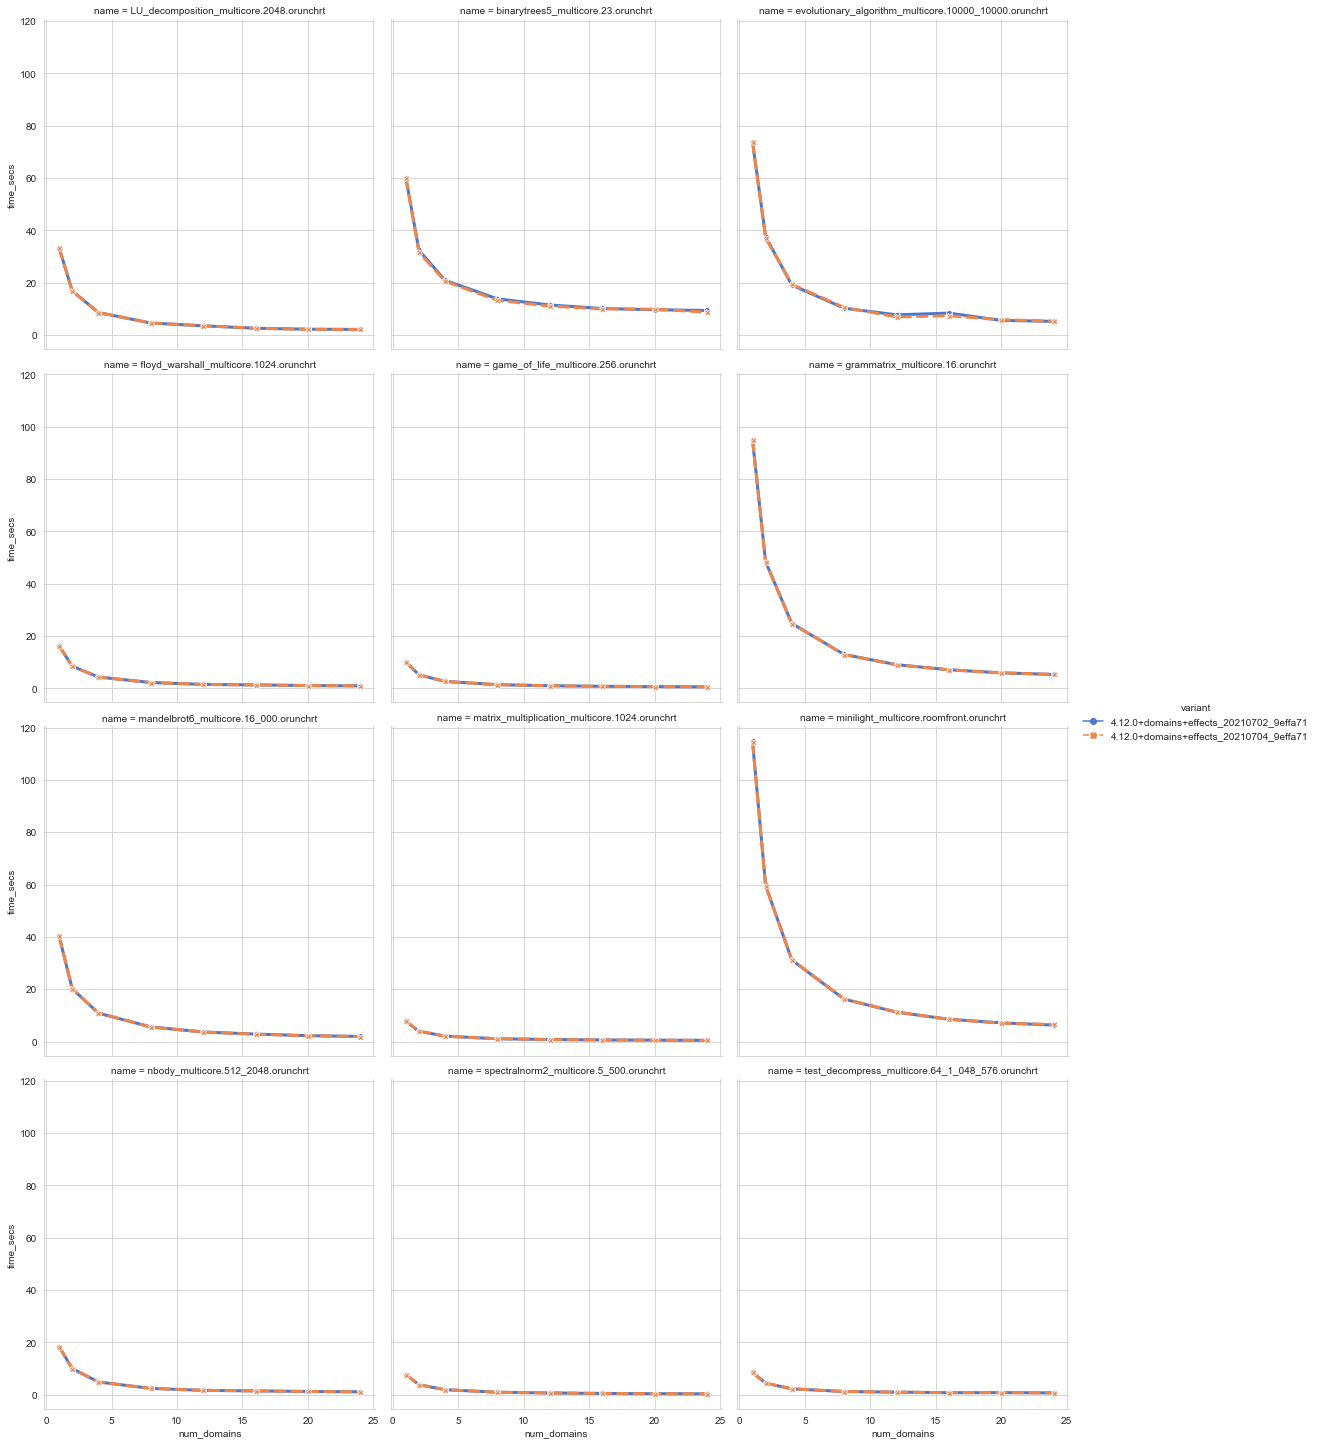

In [63]:
mdf = mdf.sort_values(['name'])
sns.relplot(x='num_domains', y = 'time_secs', hue='variant', col='name',
            data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
            lw=3, palette="muted")

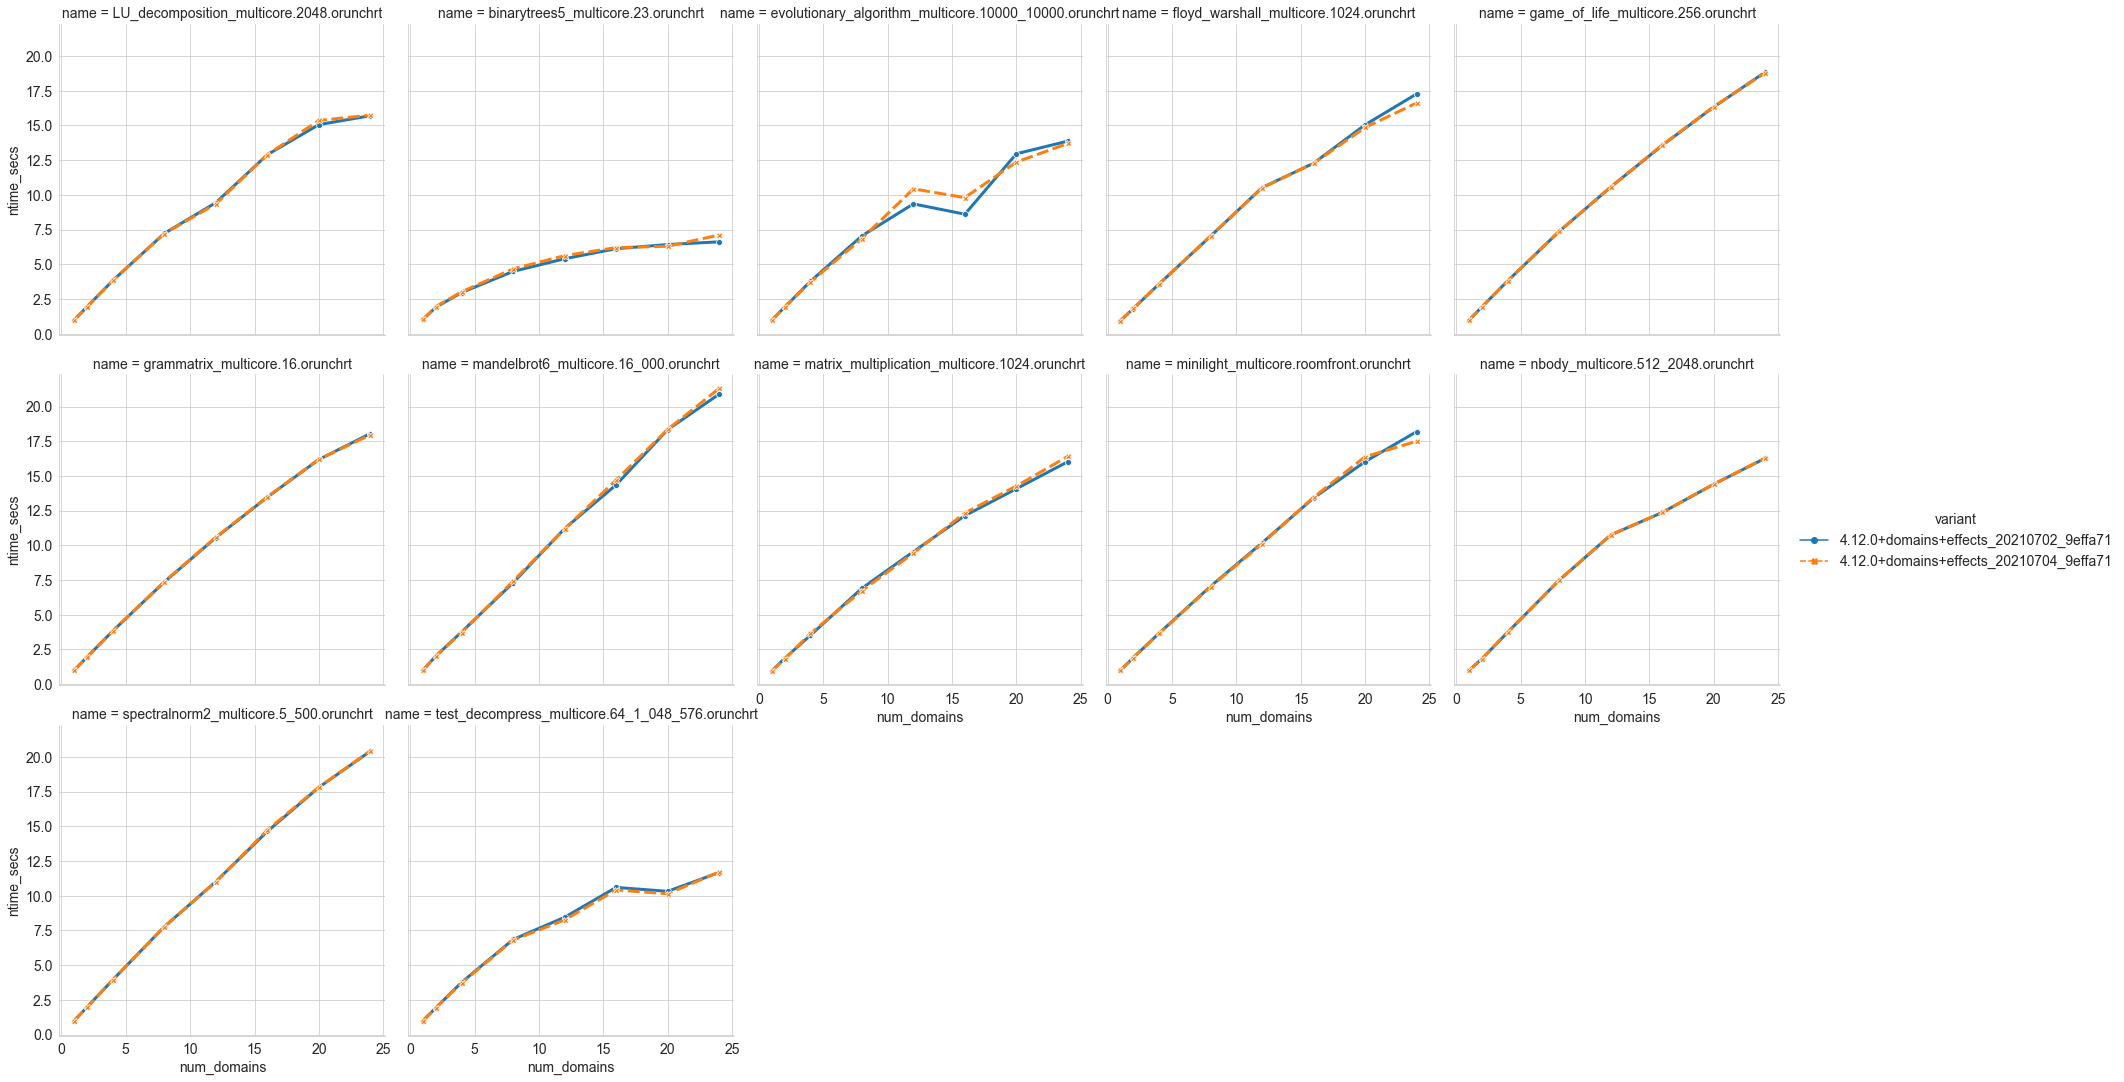

In [64]:
mdf = mdf.sort_values(['name'])
with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                              "legend.fontsize":14}):
    sns.relplot(x='num_domains', y = 'ntime_secs', hue='variant', col='name',
                data=mdf, kind='line', style='variant', markers=True, col_wrap = 5, 
                lw=3)


In [45]:
data_frames = []

for root, _, files in os.walk(pausetimes_dir):
    for file in files:
        with open(str(root + '/' + file)) as f:
            data = []
            for l in f:
                data.append(json.loads(l))
            ldf = pd.json_normalize(data)
        ldf['variant'] = file.replace("_1.pausetimes_multicore.bench","")
        data_frames.append(ldf)

df2 = pd.concat(data_frames, sort=False)

mdf2 = df2.loc[df2['name'].str.contains('.*multicore.*',regex=True),:]
mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
mdf2['name'] = mdf2['name'].replace('\..*?_','.',regex=True)

latency_df = pd.DataFrame.copy(mdf2)
mdf2.sort_values(["name"])

<ipython-input-45-39cc3a5b843e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
<ipython-input-45-39cc3a5b843e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
<ipython-input-45-39cc3a5b843e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,name,mean_latency,max_latency,distr_latency,variant,num_domains
8,LU_decomposition_multicore.2048,45399308,421271275,"[9000, 9001, 9083, 9208, 5021792, 29659234, 63...",4.12.0+domains+effects+instrumented_1.pausetim...,16
1,LU_decomposition_multicore.2048,37111528,307441147,"[9000, 9001, 9083, 9292, 7993454, 30851653, 51...",4.12.0+domains+effects+instrumented_1.pausetim...,12
31,LU_decomposition_multicore.2048,50341,1592977,"[9000, 9000, 9000, 9042, 85730, 88335, 88585, ...",4.12.0+domains+effects+instrumented_1.pausetim...,1
79,LU_decomposition_multicore.2048,16108971,126499630,"[9000, 9001, 9084, 593299, 7693787, 15689119, ...",4.12.0+domains+effects+instrumented_1.pausetim...,4
46,LU_decomposition_multicore.2048,58393646,603448401,"[9000, 9000, 9083, 9126, 2568407, 33466800, 75...",4.12.0+domains+effects+instrumented_1.pausetim...,20
...,...,...,...,...,...,...
28,test_decompress_multicore.64_1_048_576,57541317,417107107,"[9000, 9041, 9125, 10584, 34874045, 74491108, ...",4.12.0+domains+effects+instrumented_1.pausetim...,20
24,test_decompress_multicore.64_1_048_576,103771,606466,"[9000, 9000, 9001, 104784, 112418, 129684, 132...",4.12.0+domains+effects+instrumented_1.pausetim...,1
51,test_decompress_multicore.64_1_048_576,34484377,169097157,"[9000, 9009, 9084, 10375, 23338000, 45697113, ...",4.12.0+domains+effects+instrumented_1.pausetim...,12
39,test_decompress_multicore.64_1_048_576,70092512,465145964,"[9000, 9042, 9167, 10625, 41333814, 92549886, ...",4.12.0+domains+effects+instrumented_1.pausetim...,24


## Max latency

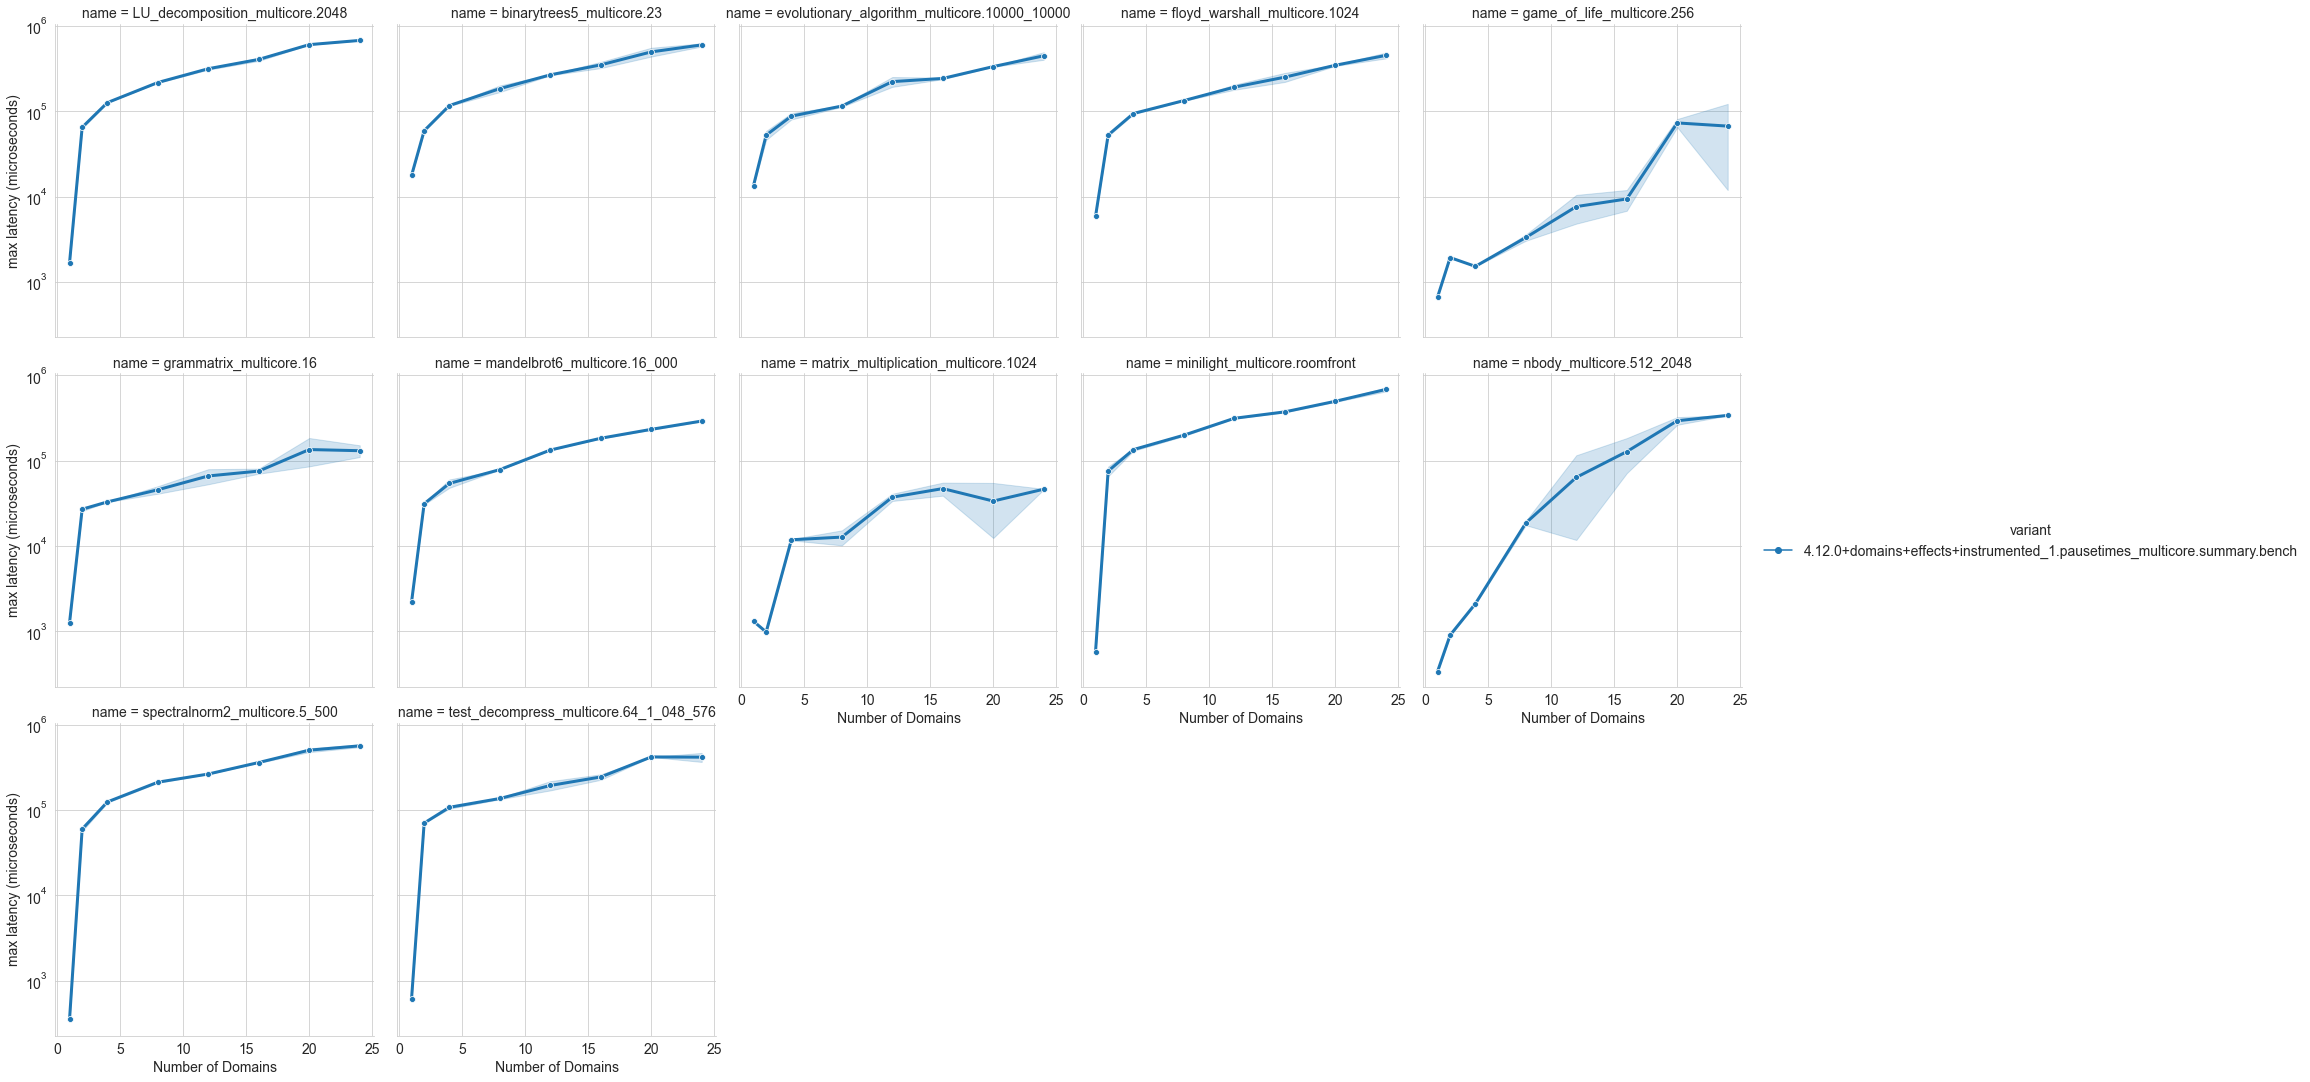

In [46]:
def plotLatencyAt(df,at):
    fdf = df.filter(["name","variant",at + "_latency","num_domains"])
    fdf.sort_values(by="name",inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                                  "legend.fontsize":14}):
        g = sns.relplot(x='num_domains', y = at + '_latency', hue='variant', col='name',
                        data=fdf, kind='line', style='variant', markers=True, col_wrap = 5, lw=3)
        for ax in g.axes:
            ax.set_ylabel(at + " latency (microseconds)")
            ax.set_xlabel("Number of Domains")
            ax.set_yscale('log')
        
plotLatencyAt(mdf2,"max")

## 99.9th percentile latency

In [47]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        for i, row in df.iterrows():
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        ndfs.append(df)
    return pd.concat(ndfs)

mdf2 = getLatencyAt(mdf2,"99.9",-1)
plotLatencyAt(mdf2,"99.9")

ValueError: Must have equal len keys and value when setting with an iterable

## 99th percentile latency

In [ ]:
mdf2 = getLatencyAt(mdf2,"99",-2)
plotLatencyAt(mdf2,"99")

## Mean latency

In [ ]:
plotLatencyAt(mdf2,"mean")